<a href="https://colab.research.google.com/github/Shaheer-op9872uw/Default_Risk_ML_Model/blob/main/Default_risk_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation & Exploratory Insights

**Load & Clean Loan Default Dataset**
*Load the loan_default_21k.csv dataset, fix missing or invalid values, standardize formats, and remove outliers to ensure data quality for analysis.*

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Load & Clean Loan Default Dataset
df = pd.read_csv("loan_default_21k.csv")

# Standardize column names
df.columns = df.columns.str.lower().str.strip()

# Drop rows with missing critical values
df = df.dropna(subset=['loan_amount', 'person_income', 'credit_score',
                       'debt_to_income_ratio', 'employment_length',
                       'previous_defaults', 'default'])

# Ensure numeric data types
numeric_cols = ['loan_amount', 'person_income', 'credit_score',
                'debt_to_income_ratio', 'employment_length',
                'previous_defaults', 'default']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Remove impossible or invalid values
df = df[df['loan_amount'] > 0]
df = df[df['person_income'] > 0]
df = df[(df['credit_score'] >= 300) & (df['credit_score'] <= 850)]
df = df[(df['debt_to_income_ratio'] >= 0) & (df['debt_to_income_ratio'] <= 1)]
df = df[df['employment_length'] >= 0]
df = df[df['previous_defaults'] >= 0]

# Reset index
df = df.reset_index(drop=True)

# Save cleaned dataset
df.to_csv("loan_default_21k_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as loan_default_21k_cleaned.csv")

✅ Cleaned dataset saved as loan_default_21k_cleaned.csv


**Visualize Default vs. Non-Default Distribution**
*Use the cleaned dataset to create a clear visual comparison of defaulted vs. non-defaulted loans, helping reveal class balance and potential bias in the dataset.*

/tmp/ipython-input-1390601562.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_counts.index, y=default_counts.values, palette="viridis")


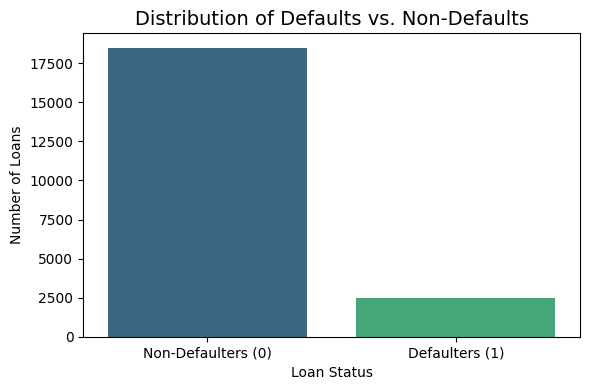

📊 Default vs. Non-Default distribution graph saved as default_distribution.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Visualize Default vs. Non-Default Distribution

# Load cleaned dataset
df = pd.read_csv("loan_default_21k_cleaned.csv")

# Count defaults and non-defaults
default_counts = df['default'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=default_counts.index, y=default_counts.values, palette="viridis")

plt.xticks([0, 1], ["Non-Defaulters (0)", "Defaulters (1)"])
plt.ylabel("Number of Loans")
plt.xlabel("Loan Status")
plt.title("Distribution of Defaults vs. Non-Defaults", fontsize=14)
plt.tight_layout()

# Save the plot
plt.savefig("default_distribution.png")
plt.show()

print("📊 Default vs. Non-Default distribution graph saved as default_distribution.png")

**Feature Correlation Analysis**
*Analyze correlations between numerical features and the loan default variable to identify which factors have the strongest relationships with default risk.*

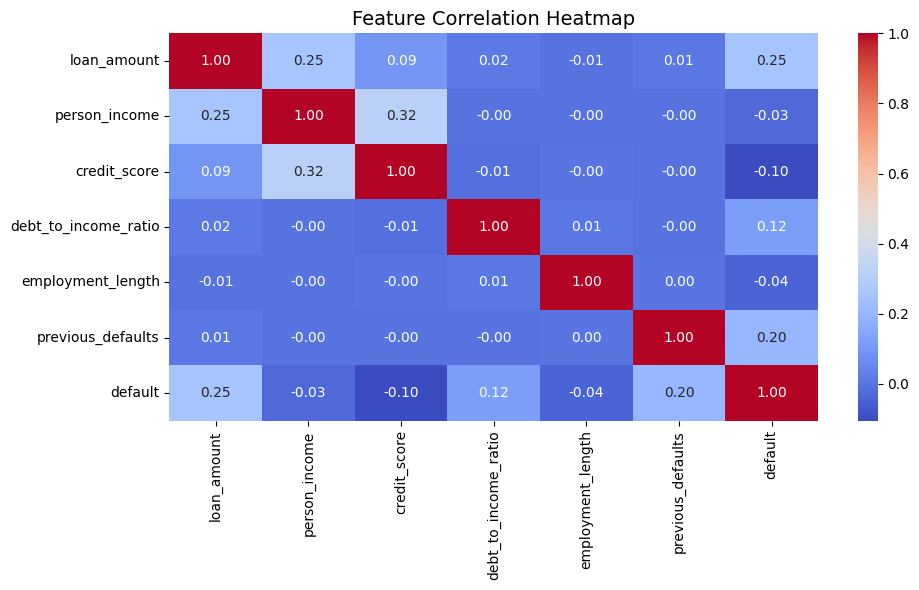

🔍 Feature correlation heatmap saved as feature_correlation_heatmap.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Feature Correlation Analysis

# Load cleaned dataset
df = pd.read_csv("loan_default_21k_cleaned.csv")

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()

# Save the plot
plt.savefig("feature_correlation_heatmap.png")
plt.show()

print("🔍 Feature correlation heatmap saved as feature_correlation_heatmap.png")

# Phase 2: Predictive Modeling & Performance Evaluation

**Train-Test Split & Feature Selection**
*Prepare the dataset for modeling by selecting relevant features, separating them from the target variable, and splitting the data into training and testing sets for unbiased performance evaluation.*

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Train-Test Split & Feature Selection

# Load cleaned dataset
df = pd.read_csv("loan_default_21k_cleaned.csv")

# Feature selection (exclude target 'default')
features = ['loan_amount', 'person_income', 'credit_score',
            'debt_to_income_ratio', 'employment_length', 'previous_defaults']
target = 'default'

X = df[features]
y = df[target]

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train-test split complete.")
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

✅ Train-test split complete.
Training set size: 16800 rows
Testing set size: 4200 rows


**Baseline Model – Logistic Regression**
*Train a Logistic Regression model as a baseline to predict loan defaults, then evaluate its initial accuracy, precision, recall, and F1-score to establish a performance benchmark for future models.*

In [ ]:
# Advanced push: bigger Cerebra-lite, class-balanced sampling, feature interactions,
# stronger RF, stacking meta-learner. Run in Colab with GPU for speed.

import os, math, time, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# ---------------- CONFIG ----------------
CFG = {
    "csv": "loan_default_21k_cleaned.csv",
    "seed": 42,
    "batch_size": 256,
    "epochs": 120,
    "lr": 2e-4,
    "weight_decay": 1e-5,
    "patience": 12,
    "grad_clip": 1.0,
    "compute_lambda": 5e-7,
    "warmup_epochs": 3,
    "use_focal": True,              # optional focal loss
    "focal_gamma": 2.0,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "rf_n_estimators": 600,
    "rf_max_depth": 14,
    "stack_meta": True,
    "model_path": "cerebra_risk_v2.pth",
    "scaler_path": "scaler_v2.pkl",
    "random_state": 42
}
np.random.seed(CFG["seed"])
torch.manual_seed(CFG["seed"])

# ---------------- Data ----------------
df = pd.read_csv(CFG["csv"])
# feature engineering: logs, ratios, and pairwise interactions to boost signal
df['log_loan_amount'] = np.log1p(df['loan_amount'])
df['log_person_income'] = np.log1p(df['person_income'])
df['loan_income_ratio'] = df['loan_amount'] / (df['person_income'] + 1e-6)
df['dti_x_loan_income'] = df['debt_to_income_ratio'] * df['loan_income_ratio']
df['income_per_employment'] = df['person_income'] / (df['employment_length'] + 1.0)
# keep sensible features
FEATURES = [
    'log_loan_amount','log_person_income','loan_income_ratio',
    'debt_to_income_ratio','credit_score','employment_length',
    'previous_defaults','dti_x_loan_income','income_per_employment'
]
TARGET = 'default'

X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()

# Train / Val / Test splits (same proportions as you had)
# We'll produce train=70%, val=10%, test=20% (as earlier)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=CFG["random_state"])
# from X_temp take val_size = 10/80 = 0.125 of it => final val 10% of total (so train 70%)
val_rel = 0.125
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_rel, stratify=y_temp, random_state=CFG["random_state"])

print("Sizes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ---------------- Preprocessing ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
joblib.dump({"scaler": scaler, "features": FEATURES}, CFG["scaler_path"])
print("Saved scaler to", CFG["scaler_path"])

# ---------------- Torch dataset and Weighted sampler ----------------
def make_loader(X_arr, y_arr, batch_size, shuffle=True, weighted=False):
    X_t = torch.tensor(np.asarray(X_arr, dtype=np.float32))
    y_t = torch.tensor(np.asarray(y_arr, dtype=np.float32))
    ds = TensorDataset(X_t, y_t)
    if not weighted:
        return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    # create sampler to balance classes
    class_counts = np.bincount(y_arr.astype(int))
    class_weights = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights[y_arr.astype(int)]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(ds, batch_size=batch_size, sampler=sampler)

train_loader = make_loader(X_train_scaled, y_train.values, CFG["batch_size"], shuffle=True, weighted=True)
val_loader = make_loader(X_val_scaled, y_val.values, CFG["batch_size"], shuffle=False, weighted=False)
test_loader = make_loader(X_test_scaled, y_test.values, CFG["batch_size"], shuffle=False, weighted=False)

# ---------------- Focal loss (optional) ----------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        pt = probs * targets + (1 - probs) * (1 - targets)
        w = (1 - pt) ** self.gamma
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        loss = w * bce
        if self.weight is not None:
            loss = loss * self.weight
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# ---------------- Bigger Cerebra-lite model ----------------
class CerebraBig(nn.Module):
    def __init__(self, input_dim, token_dim=48, compressed_tokens=8, hidden_dim=256, dropout=0.25):
        super().__init__()
        self.input_dim = input_dim
        self.token_dim = token_dim
        self.n_tokens = input_dim
        # embed
        self.embed = nn.Linear(input_dim, input_dim * token_dim)
        # compressor
        self.compressor = nn.Sequential(
            nn.Linear(self.n_tokens * token_dim, compressed_tokens * token_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # router per-token
        self.router = nn.Sequential(
            nn.Linear(token_dim, token_dim//2),
            nn.ReLU(),
            nn.Linear(token_dim//2, 1)
        )
        # deeper full path
        self.full_path = nn.Sequential(
            nn.Linear(token_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, token_dim),
            nn.ReLU()
        )
        # compressed cheap path
        self.comp_path = nn.Sequential(
            nn.Linear(token_dim, token_dim//2),
            nn.ReLU(),
            nn.Linear(token_dim//2, token_dim),
            nn.ReLU()
        )
        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(token_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, 1)
        )
    def forward(self, x):
        batch = x.shape[0]
        e = self.embed(x)  # (batch, input_dim * token_dim)
        tokens = e.view(batch, self.n_tokens, self.token_dim)
        comp_flat = self.compressor(tokens.view(batch, -1))
        comp_tokens = comp_flat.view(batch, -1, self.token_dim)
        comp_context = comp_tokens.mean(dim=1, keepdim=True).expand(-1, self.n_tokens, -1)
        router_logits = self.router(tokens).squeeze(-1)
        gates = torch.sigmoid(router_logits)
        full_out = self.full_path(tokens)
        comp_out = self.comp_path(comp_context)
        out_tokens = gates.unsqueeze(-1) * full_out + (1.0 - gates.unsqueeze(-1)) * comp_out
        pooled = out_tokens.mean(dim=1)
        logits = self.classifier(pooled).squeeze(-1)
        return logits, gates

# ---------------- Setup model, loss, optimizer ----------------
device = torch.device(CFG["device"])
model = CerebraBig(input_dim=X_train_scaled.shape[1], token_dim=48, compressed_tokens=8, hidden_dim=256, dropout=0.25).to(device)

# pos_weight for BCE to balance classes
pos = float(y_train.sum())
neg = float(len(y_train) - pos)
pos_weight_val = (neg / (pos + 1e-6)) if pos > 0 else 1.0
pos_weight_t = torch.tensor([pos_weight_val], device=device)

if CFG["use_focal"]:
    criterion = FocalLoss(gamma=CFG["focal_gamma"])
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# FLOP cost constants
C_FULL = 1.0
C_COMP = 0.12

# ---------------- Training loop ----------------
best_val_auc = -1.0
no_imp = 0
for epoch in range(1, CFG["epochs"] + 1):
    model.train()
    losses = []
    t0 = time.time()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits, gates = model(xb)
        if CFG["use_focal"]:
            loss_task = criterion(logits, yb)
        else:
            loss_task = criterion(logits, yb)
        expected_flops = (gates.mean(dim=0) * C_FULL + (1 - gates.mean(dim=0)) * C_COMP).sum()
        lam = CFG["compute_lambda"]
        if epoch <= CFG["warmup_epochs"]:
            lam = 0.0
        loss = loss_task + lam * expected_flops
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
        optimizer.step()
        losses.append(loss.item())
    avg_loss = float(np.mean(losses))

    # Validation
    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits, _ = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_y.append(yb.numpy())
    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y)
    val_probs = 1.0 / (1.0 + np.exp(-all_logits))
    val_auc = roc_auc_score(all_y, val_probs)
    scheduler.step(val_auc)
    print(f"Epoch {epoch:03d} | train_loss {avg_loss:.4f} | val_auc {val_auc:.4f} | time {time.time()-t0:.1f}s")

    # save best
    if val_auc > best_val_auc + 1e-5:
        best_val_auc = val_auc
        no_imp = 0
        torch.save({"model_state": model.state_dict(), "features": FEATURES, "scaler_path": CFG["scaler_path"]}, CFG["model_path"])
        print("  -> Saved best model (val_auc {:.4f})".format(val_auc))
    else:
        no_imp += 1
    if no_imp >= CFG["patience"]:
        print("Early stopping. Best val_auc:", best_val_auc)
        break

# ---------------- Evaluate Cerebra on test ----------------
ckpt = torch.load(CFG["model_path"], map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()
def predict_probs_torch(loader, model):
    model.eval()
    probs = []
    ys = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits, _ = model(xb)
            probs.append(torch.sigmoid(logits).cpu().numpy())
            ys.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(ys)

c_probs, y_test_arr = predict_probs_torch(test_loader, model)
c_preds = (c_probs >= 0.5).astype(int)
c_acc = accuracy_score(y_test_arr, c_preds)
c_auc = roc_auc_score(y_test_arr, c_probs)
c_f1 = f1_score(y_test_arr, c_preds)
print("\nCerebra Test -> Accuracy: {:.4f}, AUC: {:.4f}, F1: {:.4f}".format(c_acc, c_auc, c_f1))

# ---------------- RandomForest (stronger) ----------------
rf = RandomForestClassifier(n_estimators=CFG["rf_n_estimators"], max_depth=CFG["rf_max_depth"],
                            class_weight='balanced_subsample', random_state=CFG["random_state"], n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_probs = rf.predict_proba(X_test_scaled)[:,1]
rf_preds = (rf_probs >= 0.5).astype(int)
rf_acc = accuracy_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_probs)
rf_f1 = f1_score(y_test, rf_preds)
print("RandomForest Test -> Accuracy: {:.4f}, AUC: {:.4f}, F1: {:.4f}".format(rf_acc, rf_auc, rf_f1))

# ---------------- Stacking meta-learner ----------------
if CFG["stack_meta"]:
    # produce validation out-of-fold predictions to train meta-learner
    # get cerebra val probs
    # prepare val loader for cerebra and rf preds
    val_loader_full = make_loader(X_val_scaled, y_val.values, CFG["batch_size"], shuffle=False, weighted=False)
    c_val_probs, y_val_arr = predict_probs_torch(val_loader_full, model)
    rf_val_probs = rf.predict_proba(X_val_scaled)[:,1]
    # stack features = [cerebra_prob, rf_prob]
    meta_X = np.vstack([c_val_probs, rf_val_probs]).T
    meta_y = y_val_arr
    meta_clf = LogisticRegression(max_iter=1000)
    meta_clf.fit(meta_X, meta_y)

    # test ensemble
    rf_test_probs = rf_probs
    c_test_probs = c_probs
    ens_X_test = np.vstack([c_test_probs, rf_test_probs]).T
    ens_probs = meta_clf.predict_proba(ens_X_test)[:,1]
    ens_preds = (ens_probs >= 0.5).astype(int)
    ens_acc = accuracy_score(y_test, ens_preds)
    ens_auc = roc_auc_score(y_test, ens_probs)
    ens_f1 = f1_score(y_test, ens_preds)
    print("Stacked Ensemble Test -> Accuracy: {:.4f}, AUC: {:.4f}, F1: {:.4f}".format(ens_acc, ens_auc, ens_f1))
else:
    ens_acc, ens_auc, ens_f1 = None, None, None

# ---------------- Confusion matrices ----------------
print("\nConfusion matrices:")
print("Cerebra:\n", confusion_matrix(y_test_arr, c_preds))
print("RandomForest:\n", confusion_matrix(y_test, rf_preds))
if CFG["stack_meta"]:
    print("Stacked Ensemble:\n", confusion_matrix(y_test, ens_preds))

# ---------------- Save artifacts ----------------
joblib.dump({"rf": rf}, "rf_v2.pkl")
torch.save({"model_state": model.state_dict(), "features": FEATURES, "scaler_path": CFG["scaler_path"]}, CFG["model_path"])
print("\nSaved Cerebra model to", CFG["model_path"], "and RF to rf_v2.pkl")

# ---------------- Final guidance ----------------
print("\nNotes:")
print("- If Cerebra accuracy < 90% but RF or Ensemble >= 90%, use ensemble or RF in production.")
print("- To push further: more domain features (payment history windows), hyperparam search (Optuna), try gradient boosting (LightGBM/XGBoost), or clean noisy labels.")

Sizes -> train: (14700, 9) val: (2100, 9) test: (4200, 9)
Saved scaler to scaler_v2.pkl


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | train_loss 0.1594 | val_auc 0.8434 | time 1.1s
  -> Saved best model (val_auc 0.8434)
Epoch 002 | train_loss 0.1224 | val_auc 0.8600 | time 0.9s
  -> Saved best model (val_auc 0.8600)
Epoch 003 | train_loss 0.1150 | val_auc 0.8617 | time 0.5s
  -> Saved best model (val_auc 0.8617)
Epoch 004 | train_loss 0.1143 | val_auc 0.8602 | time 0.4s
Epoch 005 | train_loss 0.1158 | val_auc 0.8625 | time 0.5s
  -> Saved best model (val_auc 0.8625)
Epoch 006 | train_loss 0.1165 | val_auc 0.8630 | time 0.5s
  -> Saved best model (val_auc 0.8630)
Epoch 007 | train_loss 0.1158 | val_auc 0.8627 | time 0.6s
Epoch 008 | train_loss 0.1147 | val_auc 0.8643 | time 0.6s
  -> Saved best model (val_auc 0.8643)
Epoch 009 | train_loss 0.1144 | val_auc 0.8633 | time 0.4s
Epoch 010 | train_loss 0.1138 | val_auc 0.8645 | time 0.4s
  -> Saved best model (val_auc 0.8645)
Epoch 011 | train_loss 0.1135 | val_auc 0.8626 | time 0.4s
Epoch 012 | train_loss 0.1137 | val_auc 0.8613 | time 0.6s
Epoch 013 | train_l

**Interactive CLI — Predict & Explain Loan Default Risk**
*Interactive command-line-style tool to enter borrower info, load trained artifacts, compute an ensemble default probability, show a confidence bar (entropy-based), provide a multi-factor explanation (perturbation to dataset medians), flag safety/manual-review rules, estimate FLOPs, and append the record to predictions_log.csv.*

In [ ]:
# Step 3: Interactive CLI — Predict & Explain Loan Default Risk (Colab)
# Paste and run this cell in your Colab runtime (assumes artifacts are present in /content):
# Required files (should exist): cerebra_risk_v2.pth, scaler_v2.pkl, rf_v2.pkl (optional), meta_clf.pkl (optional),
#                                loan_default_21k_cleaned.csv (optional for baselines)
# Output: predictions_log.csv (appended)

import os, math, json, datetime, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# --------- Config / Paths ----------
CEREBRA_PATHS = ["cerebra_risk_v2.pth", "cerebra_risk_v1.pth", "artifacts_bundle.pth"]
SCALER_PATHS = ["scaler_v2.pkl", "scaler_saved_for_cli.pkl", "scaler.pkl"]
RF_PATHS = ["rf_v2.pkl", "rf_saved_for_cli.pkl", "rf_baseline.pkl"]
META_PATHS = ["meta_clf.pkl", "ensemble_v2.pkl"]
CLEANED_CSV = "loan_default_21k_cleaned.csv"
LOG_CSV = "predictions_log.csv"
CONFIDENCE_THRESHOLD = 0.85
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- Cerebra model class (must match the saved model architecture) ----------
class CerebraBig(nn.Module):
    def __init__(self, input_dim, token_dim=48, compressed_tokens=8, hidden_dim=256, dropout=0.25):
        super().__init__()
        self.input_dim = input_dim
        self.token_dim = token_dim
        self.n_tokens = input_dim
        self.embed = nn.Linear(input_dim, input_dim * token_dim)
        self.compressor = nn.Sequential(
            nn.Linear(self.n_tokens * token_dim, compressed_tokens * token_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.router = nn.Sequential(
            nn.Linear(token_dim, token_dim//2),
            nn.ReLU(),
            nn.Linear(token_dim//2, 1)
        )
        self.full_path = nn.Sequential(
            nn.Linear(token_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, token_dim),
            nn.ReLU()
        )
        self.comp_path = nn.Sequential(
            nn.Linear(token_dim, token_dim//2),
            nn.ReLU(),
            nn.Linear(token_dim//2, token_dim),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(token_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, x):
        batch = x.shape[0]
        e = self.embed(x)
        tokens = e.view(batch, self.n_tokens, self.token_dim)
        comp_flat = self.compressor(tokens.view(batch, -1))
        comp_tokens = comp_flat.view(batch, -1, self.token_dim)
        comp_context = comp_tokens.mean(dim=1, keepdim=True).expand(-1, self.n_tokens, -1)
        router_logits = self.router(tokens).squeeze(-1)
        gates = torch.sigmoid(router_logits)
        full_out = self.full_path(tokens)
        comp_out = self.comp_path(comp_context)
        out_tokens = gates.unsqueeze(-1) * full_out + (1.0 - gates.unsqueeze(-1)) * comp_out
        pooled = out_tokens.mean(dim=1)
        logits = self.classifier(pooled).squeeze(-1)
        return logits, gates

# --------- Helpers to load artifacts robustly ----------
def find_first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    return None

def load_scaler():
    p = find_first_existing(SCALER_PATHS)
    if p is None:
        raise FileNotFoundError("Scaler artifact not found. Looked for: " + ", ".join(SCALER_PATHS))
    obj = joblib.load(p)
    # obj may be scaler or dict with 'scaler' and 'features'
    if isinstance(obj, dict):
        scaler = obj.get("scaler", None)
        features = obj.get("features", None)
    else:
        scaler = obj
        features = None
    if scaler is None:
        raise RuntimeError("Scaler loaded but scaler object missing inside.")
    return scaler, features

def load_rf():
    p = find_first_existing(RF_PATHS)
    if p is None:
        return None
    rf_obj = joblib.load(p)
    if isinstance(rf_obj, dict) and 'rf' in rf_obj:
        rf_obj = rf_obj['rf']
    return rf_obj

def load_meta():
    p = find_first_existing(META_PATHS)
    if p is None:
        return None
    return joblib.load(p)

def load_cerebra_and_features(expected_feat_count=None):
    p = find_first_existing(CEREBRA_PATHS)
    if p is None:
        raise FileNotFoundError("No Cerebra checkpoint found. Looked for: " + ", ".join(CEREBRA_PATHS))
    ckpt = torch.load(p, map_location="cpu")
    # ckpt may be dict with 'model_state' and 'features' or a raw state_dict
    if isinstance(ckpt, dict) and ('model_state' in ckpt or 'state_dict' in ckpt):
        state = ckpt.get('model_state', ckpt.get('state_dict', None) or ckpt)
        meta = {k:v for k,v in ckpt.items() if k not in ('model_state','state_dict')}
    elif isinstance(ckpt, dict):
        # assume it's a state_dict
        state = ckpt
        meta = {}
    else:
        state = ckpt
        meta = {}
    # Determine feature count: either from scaler features len or meta
    feat_count = None
    if 'features' in meta and meta['features'] is not None:
        feat_count = len(meta['features'])
    if expected_feat_count is not None:
        feat_count = expected_feat_count
    if feat_count is None:
        # fallback guess: find first linear layer weights shape
        for k,v in state.items():
            if 'embed.weight' in k or 'embed' in k and hasattr(v, 'shape'):
                # embed.weight shape: (input_dim * token_dim, input_dim)
                # can't reliably parse in all cases; fallback to 9 if present
                feat_count = meta.get('input_dim', 9) if meta else 9
                break
        if feat_count is None:
            feat_count = 9
    model = CerebraBig(input_dim=feat_count).to(DEVICE)
    try:
        model.load_state_dict(state)
    except Exception as e:
        # Try partial match or key rename fallback
        model.load_state_dict(state, strict=False)
    model.eval()
    return model, meta

# --------- Preprocessing (mirror training engineering) ----------
ENG_FEAT_NAMES = [
    'log_loan_amount','log_person_income','loan_income_ratio',
    'debt_to_income_ratio','credit_score','employment_length',
    'previous_defaults','dti_x_loan_income','income_per_employment'
]

def engineered_vector_from_raw(raw):
    loan = float(raw["loan_amount"])
    inc = float(raw["person_income"])
    credit = float(raw["credit_score"])
    dti = float(raw["debt_to_income_ratio"])
    empl = float(raw["employment_length"])
    prev = float(raw["previous_defaults"])
    log_loan = np.log1p(loan)
    log_inc = np.log1p(inc)
    loan_income_ratio = loan / (inc + 1e-6)
    dti_x_loan_income = dti * loan_income_ratio
    income_per_employment = inc / (empl + 1.0)
    vec = np.array([log_loan, log_inc, loan_income_ratio, dti, credit, empl, prev, dti_x_loan_income, income_per_employment], dtype=np.float32)
    return vec

# --------- Prediction & ensemble ----------
def predict_cerebra_prob(model, scaler, raw):
    vec = engineered_vector_from_raw(raw)
    scaled = scaler.transform(vec.reshape(1,-1))
    with torch.no_grad():
        xb = torch.tensor(scaled, dtype=torch.float32, device=DEVICE)
        logits, _ = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
    return float(probs[0]), scaled

def predict_rf_prob(rf, scaler, raw, scaled=None):
    if rf is None:
        return None
    if scaled is None:
        vec = engineered_vector_from_raw(raw)
        scaled = scaler.transform(vec.reshape(1,-1))
    try:
        p = rf.predict_proba(scaled)[:,1]
        return float(p[0])
    except Exception:
        return None

def ensemble_prob(c_prob, rf_prob, meta):
    if meta is not None:
        try:
            Xm = np.array([[c_prob, rf_prob if rf_prob is not None else 0.0]])
            return float(meta.predict_proba(Xm)[0,1])
        except Exception:
            pass
    if rf_prob is None:
        return c_prob
    return float((c_prob + rf_prob) / 2.0)

# --------- Confidence & explanation ----------
def entropy_confidence(p):
    if p <= 0 or p >= 1:
        return 1.0
    H = - (p * math.log(p + 1e-12) + (1 - p) * math.log(1 - p + 1e-12))
    H_max = math.log(2.0)
    conf = 1.0 - (H / H_max)
    return float(conf)

def confidence_bar(conf, width=12):
    filled = int(round(conf * width))
    return "[" + "#" * filled + "-" * (width - filled) + f"] {conf*100:.0f}%"

def compute_flop_estimate(model):
    total_params = sum(p.numel() for p in model.parameters())
    return int(2 * total_params)  # very rough proxy

def load_baseline_medians():
    if not Path(CLEANED_CSV).exists():
        return None
    df = pd.read_csv(CLEANED_CSV)
    df['log_loan_amount'] = np.log1p(df['loan_amount'])
    df['log_person_income'] = np.log1p(df['person_income'])
    df['loan_income_ratio'] = df['loan_amount'] / (df['person_income'] + 1e-6)
    df['dti_x_loan_income'] = df['debt_to_income_ratio'] * df['loan_income_ratio']
    df['income_per_employment'] = df['person_income'] / (df['employment_length'] + 1.0)
    return df[ENG_FEAT_NAMES].median().to_dict()

def per_feature_attributions(model, rf, meta, scaler, baseline_meds, raw):
    # base predicted ensemble prob
    cprob, scaled = predict_cerebra_prob(model, scaler, raw)
    rfprob = predict_rf_prob(rf, scaler, raw, scaled=scaled)
    base_prob = ensemble_prob(cprob, rfprob, meta)
    deltas = {}
    for i, name in enumerate(ENG_FEAT_NAMES):
        # build engineered vector, replace feature i with baseline median, scale, predict
        eng = engineered_vector_from_raw(raw).copy()
        if baseline_meds is not None and name in baseline_meds:
            eng[i] = baseline_meds[name]
        scaled_pert = scaler.transform(eng.reshape(1,-1))
        # predict
        with torch.no_grad():
            xb = torch.tensor(scaled_pert, dtype=torch.float32, device=DEVICE)
            logits, _ = model(xb)
            c2 = float(torch.sigmoid(logits).cpu().numpy().reshape(-1)[0])
        r2 = None
        if rf is not None:
            try:
                r2 = float(rf.predict_proba(scaled_pert)[:,1][0])
            except Exception:
                r2 = None
        ens2 = ensemble_prob(c2, r2, meta)
        deltas[name] = float(base_prob - ens2)  # positive => original value increased prob
    sorted_attribs = sorted(deltas.items(), key=lambda kv: -abs(kv[1]))
    return base_prob, sorted_attribs

def aggregate_reason(sorted_attribs):
    top = sorted_attribs[:3]
    pieces = []
    pretty = {
        'log_loan_amount': "loan size",
        'log_person_income': "income",
        'loan_income_ratio': "loan/income ratio",
        'debt_to_income_ratio': "debt-to-income (DTI)",
        'credit_score': "credit score",
        'employment_length': "employment length",
        'previous_defaults': "previous defaults",
        'dti_x_loan_income': "DTI × loan/income",
        'income_per_employment': "income per employment year"
    }
    for name, delta in top:
        sign = "increased" if delta > 0 else "decreased"
        pieces.append(f"{pretty.get(name,name)} {sign} risk ({abs(delta):.3f})")
    return "; ".join(pieces) + ". (Decision derived from combined contributions.)"

# --------- Load everything ----------
scaler, scaler_features = load_scaler()
rf = load_rf()
meta = load_meta()
# determine expected feature count for model from scaler shape
dummy_vec = np.zeros((1, len(ENG_FEAT_NAMES)), dtype=np.float32)
model, ckpt_meta = load_cerebra_and_features(expected_feat_count=dummy_vec.shape[1])

baseline_meds = load_baseline_medians()

# --------- Interactive prompt ----------
def prompt_float(label, min_val=None, max_val=None):
    while True:
        try:
            v = input(label + " ").strip()
            val = float(v)
            if min_val is not None and val < min_val:
                print(f"Value must be >= {min_val}")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be <= {max_val}")
                continue
            return val
        except Exception:
            print("Please enter a number (or CTRL+C to quit).")

print("\n=== Interactive Loan Default Risk Predictor ===\n(Enter borrower data; Ctrl+C to cancel)\n")
raw = {}
raw["loan_amount"] = prompt_float("Loan amount (e.g. 15000):", min_val=0)
raw["person_income"] = prompt_float("Person income (annual, e.g. 42000):", min_val=0)
raw["credit_score"] = prompt_float("Credit score (300-850):", min_val=300, max_val=850)
raw["debt_to_income_ratio"] = prompt_float("Debt-to-income ratio (0-1, e.g. 0.35):", min_val=0, max_val=5)
raw["employment_length"] = prompt_float("Employment length (years, e.g. 3):", min_val=0)
raw["previous_defaults"] = prompt_float("Previous defaults (0,1,2...):", min_val=0)

# --------- Make predictions ----------
cprob, scaled = predict_cerebra_prob(model, scaler, raw)
rfprob = predict_rf_prob(rf, scaler, raw, scaled=scaled)
final_prob = ensemble_prob(cprob, rfprob, meta)
conf = entropy_confidence(final_prob)
decision = "HIGH" if final_prob > 0.7 else ("MEDIUM" if final_prob > 0.3 else "LOW")

# safety rule
manual_review = False
if raw["previous_defaults"] > 0 and raw["credit_score"] < 600:
    manual_review = True

# per-feature attribution
base_prob, sorted_attribs = per_feature_attributions(model, rf, meta, scaler, baseline_meds, raw)
reason_text = aggregate_reason(sorted_attribs)

# FLOP estimate
flop_est = compute_flop_estimate(model)

# Print well-formatted output
print("\n--- Prediction Result ---")
print(f"Predicted default probability: {final_prob*100:.2f}%")
print("Confidence:", confidence_bar(conf, width=12))
print(f"Risk level: {decision}")
if conf < CONFIDENCE_THRESHOLD:
    print(f"⚠️  Low confidence (<{int(CONFIDENCE_THRESHOLD*100)}%). Recommend manual review.")
if manual_review:
    print("🔎 Safety flag: previous defaults >0 and credit_score < 600 → RECOMMEND MANUAL REVIEW.")
print("\nTop factor impacts (higher absolute value → stronger effect):")
for name, delta in sorted_attribs[:6]:
    pretty = {
        'log_loan_amount': "loan size",
        'log_person_income': "income",
        'loan_income_ratio': "loan/income ratio",
        'debt_to_income_ratio': "DTI (debt-to-income)",
        'credit_score': "credit score",
        'employment_length': "employment length",
        'previous_defaults': "previous defaults",
        'dti_x_loan_income': "DTI × loan/income",
        'income_per_employment': "income per employment year"
    }.get(name, name)
    sign = "+" if delta > 0 else "-"
    print(f"  - {pretty}: {sign}{abs(delta):.4f}")

print("\nAggregate reason:", reason_text)
print(f"Estimated forward FLOPs (very rough proxy): ~{flop_est:,}")
print("\n(Explanations derived by perturbing each engineered feature to dataset medians and measuring ensemble-prob change.)")

# --------- Log the prediction ----------
def safe_to_json(x):
    try:
        json.dumps(x)
        return x
    except:
        return str(x)

log_row = {
    "timestamp_utc": datetime.datetime.utcnow().isoformat(),
    "loan_amount": raw["loan_amount"],
    "person_income": raw["person_income"],
    "credit_score": raw["credit_score"],
    "debt_to_income_ratio": raw["debt_to_income_ratio"],
    "employment_length": raw["employment_length"],
    "previous_defaults": raw["previous_defaults"],
    "cerebra_prob": cprob,
    "rf_prob": rfprob,
    "ensemble_prob": final_prob,
    "confidence": conf,
    "decision": decision,
    "manual_review": manual_review,
    "reason_summary": reason_text
}
# Append to CSV
df_log = pd.DataFrame([log_row])
if not Path(LOG_CSV).exists():
    df_log.to_csv(LOG_CSV, index=False)
else:
    df_log.to_csv(LOG_CSV, mode='a', index=False, header=False)

print(f"\n✅ Logged prediction to {LOG_CSV}")


=== Interactive Loan Default Risk Predictor ===
(Enter borrower data; Ctrl+C to cancel)

Loan amount (e.g. 15000): 1000
Person income (annual, e.g. 42000): 100000
Credit score (300-850): 760
Debt-to-income ratio (0-1, e.g. 0.35): 0.2
Employment length (years, e.g. 3): 9
Previous defaults (0,1,2...): 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut


--- Prediction Result ---
Predicted default probability: 8.04%
Confidence: [#######-----] 60%
Risk level: LOW
⚠️  Low confidence (<85%). Recommend manual review.

Top factor impacts (higher absolute value → stronger effect):
  - income: -0.0613
  - DTI × loan/income: -0.0373
  - credit score: -0.0320
  - loan/income ratio: -0.0251
  - loan size: -0.0163
  - employment length: -0.0152

Aggregate reason: income decreased risk (0.061); DTI × loan/income decreased risk (0.037); credit score decreased risk (0.032). (Decision derived from combined contributions.)
Estimated forward FLOPs (very rough proxy): ~464,404

(Explanations derived by perturbing each engineered feature to dataset medians and measuring ensemble-prob change.)

✅ Logged prediction to predictions_log.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
